In [2]:
import polars as pl
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import matplotlib.cm as cm

group_dir = "/home/ubuntu/cloudgroupe2e"

In [13]:
# Read the group's entire data

lazy_results_df = (
  pl.scan_parquet(f"{group_dir}/results.parquet")
)
exp_results_df = lazy_results_df

configurations_df = (
  pl.read_parquet(f"{group_dir}/configurations.parquet")
)
pd_configurations_df = configurations_df.to_pandas()

metrics_df = (
  pl.read_parquet(f"{group_dir}/metrics.parquet")
)
pd_metrics_df = (
  metrics_df
  .to_pandas()
  .sort_values(by=["node_type", "trial", "observation_timestamp"])
)

pd_metrics_df

,node_type,metric_type,trial,metric_value,observation_timestamp,exp_id
635,originserver,cpu_utilization,1,0.7,0,cloud_proxy_and_500mbpsattacker_withattacker
755,originserver,memory_utilization,1,218.0,0,cloud_proxy_and_500mbpsattacker_withattacker
4457,originserver,cpu_utilization,1,1.2,0,cloud_proxy_and_500mbpsattacker_withattacker_d...
4577,originserver,memory_utilization,1,229.0,0,cloud_proxy_and_500mbpsattacker_withattacker_d...
4578,originserver,memory_utilization,1,229.0,0,cloud_proxy_and_500mbpsattacker_withattacker_d...
...,...,...,...,...,...,...
33819,proxy,memory_utilization,3,4502.0,120,cloud_proxy_and_attacker_withattacker
37648,proxy,memory_utilization,3,1124.0,120,cloud_proxy_and_attacker_withattacker_dtlson
37649,proxy,memory_utilization,3,1124.0,120,cloud_proxy_and_attacker_withattacker_dtlson
41476,proxy,memory_utilization,3,1108.0,120,cloud_proxy_and_attacker_withattacker_dtlson_h...


In [9]:
%%time

client_sends_df = (
  exp_results_df
  .filter(
    (pl.col("message_source").str.contains("client"))
    & (pl.col("node_type").str.contains("client"))
  )
)
client_recvs_df = (
  exp_results_df
  .filter(
    (pl.col("message_destination").str.contains("client"))
    & (pl.col("node_type").str.contains("client"))
  )
)

rtts_df = (
  client_sends_df
  .join(
    client_recvs_df,
    on=["trial", "node_type", "message_marker"],
    how="left",
  )
  .groupby(by=["exp_id", "trial", "node_type", "message_marker"])
  .agg([
    pl.col("coap_code").first().alias("response_code"),
    pl.col("message_timestamp").min().alias("send_time_sec"),
    pl.col("message_timestamp_right").min().alias("recv_time_sec"),
    pl.col("message_timestamp").min().alias("first_send_time_sec"),
    pl.col("message_timestamp").max().alias("last_send_time_sec"),
    pl.col("message_timestamp_right").min().alias("first_recv_time_sec"),
    pl.col("message_timestamp_right").max().alias("last_recv_time_sec"),
    pl.col("message_timestamp").count().alias("num_send_observations"),
    pl.col("message_timestamp_right").count().alias("num_recv_observations"),
    (pl.col("coap_retransmitted") == True).sum().alias("num_retransmissions"),
  ])
  .with_columns([
    (1e3 * (pl.col("first_recv_time_sec") - pl.col("first_send_time_sec"))).alias("rtt_ms_first_transmission"),
    (1e3 * (pl.col("first_recv_time_sec") - pl.col("last_send_time_sec"))).alias("rtt_ms_last_transmission"),
  ])
  .sort(by=["exp_id", "trial", "node_type", "message_marker"])
)

stats_df = (
  rtts_df
  .groupby(by=["exp_id", "trial", "node_type"])
  .agg([
    pl.col("message_marker").n_unique().alias("num_messages"),
    pl.col("send_time_sec").min().alias("global_first_send_time_sec"),
    pl.col("recv_time_sec").max().alias("global_last_recv_time_sec"),
  ])
  .with_columns([
    (pl.col("num_messages") / (pl.col("global_last_recv_time_sec") - pl.col("global_first_send_time_sec"))).alias("average_rps"),
  ])
  .filter(
    pl.col("node_type").str.contains("client")
  )
)

rtts_df = (
  rtts_df.join(
    stats_df,
    on=["exp_id", "trial", "node_type"],
    how="left",
  )
  .collect()
  .to_pandas()
)

message_rtt_df = rtts_df
message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df

['get']
CPU times: user 42.2 s, sys: 32.6 s, total: 1min 14s
Wall time: 20.5 s


,exp_id,trial,node_type,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,...,num_send_observations,num_recv_observations,num_retransmissions,rtt_ms_first_transmission,rtt_ms_last_transmission,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps,successful_message
0,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,1,get,0.000000,0.142585,0.000000,0.000000,0.142585,...,12,12,0,142.585039,142.585039,1348,0.0,97.301259,13.853880,False
1,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,2,get,0.231558,0.215283,0.231558,0.231558,0.215283,...,12,12,0,-16.275167,-16.275167,1348,0.0,97.301259,13.853880,False
2,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,3,get,0.290401,0.276118,0.290401,0.290401,0.276118,...,12,12,0,-14.282942,-14.282942,1348,0.0,97.301259,13.853880,False
3,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,4,get,0.348780,0.337057,0.348780,0.348780,0.337057,...,12,12,0,-11.723280,-11.723280,1348,0.0,97.301259,13.853880,False
4,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,5,get,0.406691,0.398103,0.406691,0.406691,0.398103,...,12,12,0,-8.588076,-8.588076,1348,0.0,97.301259,13.853880,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57548,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518420,get,98.437647,98.490177,98.437647,98.437647,98.490177,...,1,1,0,52.530050,52.530050,1368,0.0,98.649930,13.867217,False
57549,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518421,get,98.490717,98.543373,98.490717,98.490717,98.543373,...,1,1,0,52.655935,52.655935,1368,0.0,98.649930,13.867217,False
57550,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518422,get,98.543918,98.596621,98.543918,98.543918,98.596621,...,1,1,0,52.702904,52.702904,1368,0.0,98.649930,13.867217,False
57551,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518423,get,98.597216,98.649930,98.597216,98.597216,98.649930,...,1,1,0,52.713871,52.713871,1368,0.0,98.649930,13.867217,False


In [11]:
message_rtt_df["observer_id"] = message_rtt_df["node_type"]

In [14]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(pd_configurations_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df

CPU times: user 305 ms, sys: 13.4 ms, total: 318 ms
Wall time: 316 ms


,exp_id,trial,observer_id,num_messages,num_successful_messages,num_retransmissions,stddev_rtt_ms,min_rtt_ms,median_rtt_ms,max_rtt_ms,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,1348,0,5,318.191454,-16.275167,52.555084,7602.551937,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,coap,http,attacker
1,cloud_proxy_and_500mbpsattacker_withattacker,2,client1,1375,0,4,393.399395,7.383823,52.541494,12678.251028,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,coap,http,attacker
2,cloud_proxy_and_500mbpsattacker_withattacker,3,client1,1373,0,4,312.459188,-17.952919,52.546024,8044.008970,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,coap,http,attacker
3,cloud_proxy_and_500mbpsattacker_withattacker_d...,1,client1,1600,0,2,4456.768530,-56653.749943,52.652121,8975.060940,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,dtls,http,attacker
4,cloud_proxy_and_500mbpsattacker_withattacker_d...,2,client1,1549,0,3,359.694794,-3193.634272,52.710056,9089.024067,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,dtls,http,attacker
5,cloud_proxy_and_500mbpsattacker_withattacker_d...,3,client1,1579,0,2,260.339391,-358.482122,52.654505,9309.669971,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,dtls,http,attacker
6,cloud_proxy_and_500mbpsattacker_withattacker_d...,1,client1,1596,0,3,4742.878728,-59513.997078,-2705.106020,6310.120106,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,dtls,https,attacker
7,cloud_proxy_and_500mbpsattacker_withattacker_d...,2,client1,1546,0,3,7382.480112,-51629.169941,-1576.577067,4210.739851,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,dtls,https,attacker
8,cloud_proxy_and_500mbpsattacker_withattacker_d...,3,client1,1556,0,3,6367.596678,-38489.850760,52.752972,8908.905029,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,dtls,https,attacker
9,cloud_proxy_and_500mbpsattacker_withattacker_h...,1,client1,1556,0,3,5651.545626,-48991.306067,52.736998,8294.707060,...,cloud_proxy_cloud_attacker,50,5,2,5,1,reuse-connections,dtls,https,attacker


In [15]:
message_rtt_df = message_rtt_df.merge(pd_configurations_df, on="exp_id")
message_rtt_df

,exp_id,trial,node_type,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,1,get,0.000000,0.142585,0.000000,0.000000,0.142585,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,False,True
1,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,2,get,0.231558,0.215283,0.231558,0.231558,0.215283,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,False,True
2,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,3,get,0.290401,0.276118,0.290401,0.290401,0.276118,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,False,True
3,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,4,get,0.348780,0.337057,0.348780,0.348780,0.337057,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,False,True
4,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,5,get,0.406691,0.398103,0.406691,0.406691,0.398103,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57548,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518420,get,98.437647,98.490177,98.437647,98.437647,98.490177,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,True,True
57549,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518421,get,98.490717,98.543373,98.490717,98.490717,98.543373,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,True,True
57550,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518422,get,98.543918,98.596621,98.543918,98.543918,98.596621,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,True,True
57551,cloud_proxy_and_attacker_withattacker_httpson,3,client1,518423,get,98.597216,98.649930,98.597216,98.597216,98.649930,...,cloud_proxy_cloud_attacker,50,5,2,5,1,True,False,True,True


<IPython.core.display.Javascript object>


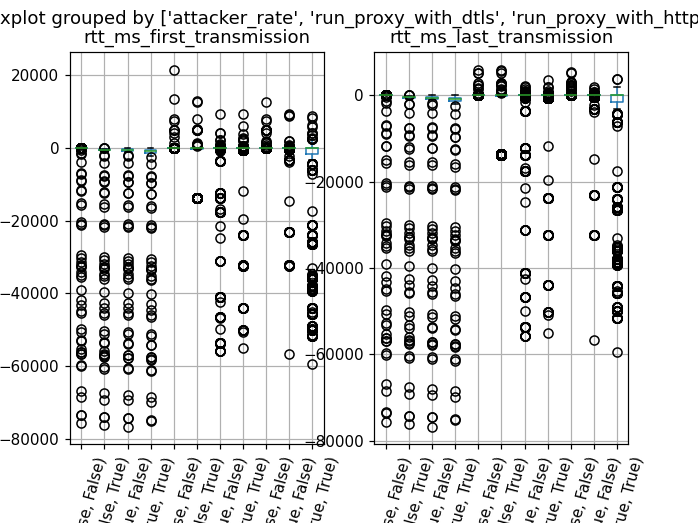

average_rps
attacker_rate run_proxy_with_dtls run_proxy_with_https             
0mbps         False               False                 -245.666525
                                  True                  -750.347830
              True                False                 -837.567043
                                  True                 -1194.409172
100mbps       False               False                   66.969792
                                  True                 -2582.958975
              True                False                 -805.117696
                                  True                  -451.075501
500mbps       False               False                   60.021957
              True                False                 -229.395379
                                  True                 -1490.407414

In [16]:
%matplotlib notebook

df = message_rtt_df
param_comparison_scope = ["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "rot": 75,
  "by": param_comparison_scope,
}

plots = ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
_, axes = plt.subplots(1, len(plots))
for i, p in enumerate(plots):
  df.boxplot(p, ax=axes[i], **plot_args)

plt.show()

(
  message_rtt_df
  .groupby(by=["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"])
  .agg(
    average_rps=("rtt_ms_first_transmission", "mean")
  )
)

<IPython.core.display.Javascript object>


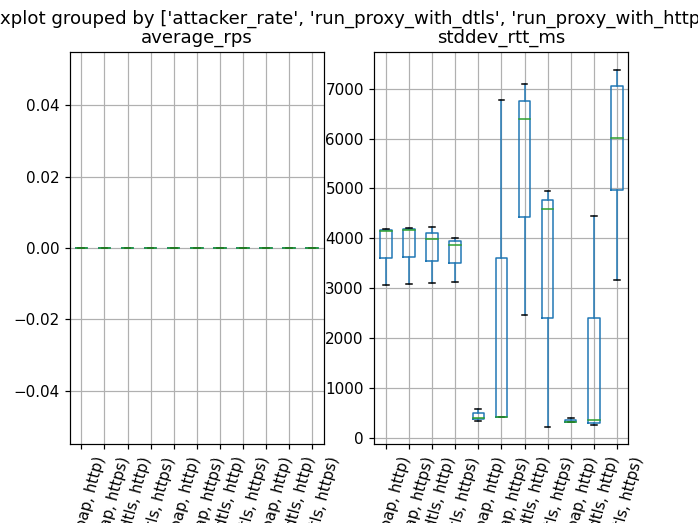

In [17]:
df = client_rps_df
param_comparison_scope = ["attacker_rate", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "rot": 75,
  "by": param_comparison_scope,
}

plots = ["average_rps", "stddev_rtt_ms"]
_, axes = plt.subplots(1, len(plots))
for i, p in enumerate(plots):
  df.boxplot(p, ax=axes[i], **plot_args)

plt.show()

<IPython.core.display.Javascript object>


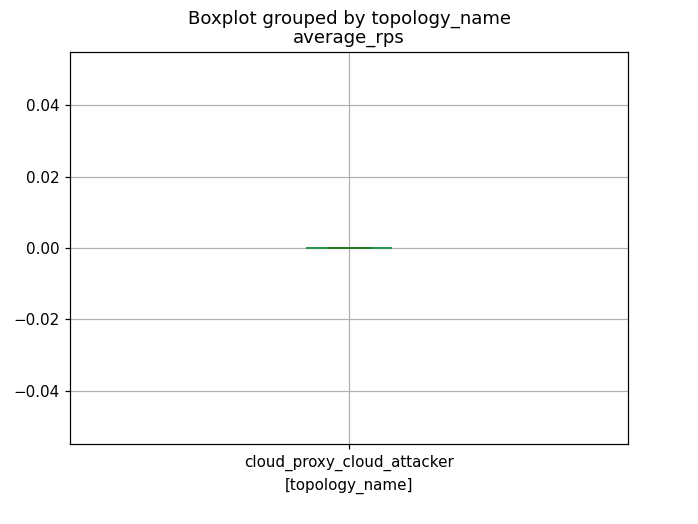

In [18]:
param_comparison_scope = ["topology_name"]

ax = None
ax = df.boxplot("average_rps", by=param_comparison_scope, ax=ax)
plt.show()

<IPython.core.display.Javascript object>


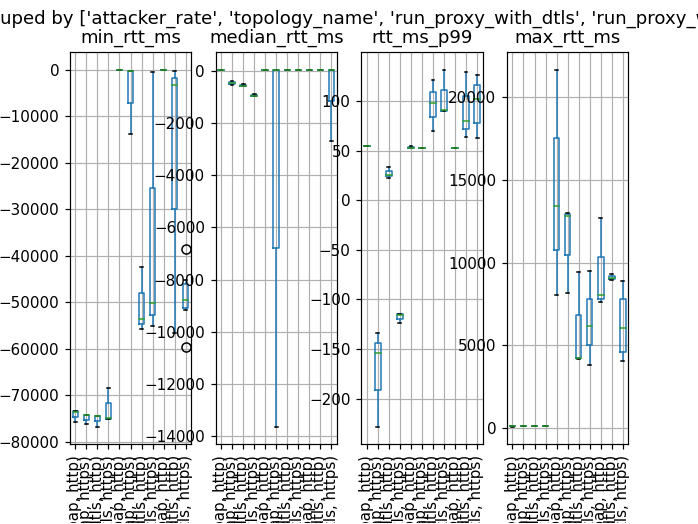

In [19]:
param_comparison_scope = ["attacker_rate", "topology_name", "run_proxy_with_dtls", "run_proxy_with_https"]

plot_args = {
  "by": param_comparison_scope,
  "rot": 90,
}

_, axes = plt.subplots(1, 4)

df.boxplot("min_rtt_ms", ax=axes[0], **plot_args)
df.boxplot("median_rtt_ms", ax=axes[1], **plot_args)
df.boxplot("rtt_ms_p99", ax=axes[2], **plot_args)
df.boxplot("max_rtt_ms", ax=axes[3], **plot_args)

plt.show()